In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

: 

In [ ]:
df = pd.read_csv('dataset/tourists_with_global_event.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'
# Select 2 features for modeling: Value (target) and Global_Event (input feature)
df = df[['Value', 'Global_Event']]
print(f"Data shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

: 

In [ ]:
df

: 

In [ ]:
df.plot(figsize=(12,6))

: 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

: 

In [ ]:
results = seasonal_decompose(df['Value'])
results.plot();     

: 

In [ ]:
len(df)

: 

In [68]:
train = df.iloc[:330]
test = df.iloc[330:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Create and fit scaler on the 2-feature training data
scaler = MinMaxScaler()
scaler.fit(train)

In [70]:
df.head(),df.tail()

(            Value  Global_Event
 Date                           
 1995-01-01  22207             0
 1995-02-01  28240             0
 1995-03-01  34219             0
 1995-04-01  33994             0
 1995-05-01  27843             0,
              Value  Global_Event
 Date                            
 2024-08-01   72717             0
 2024-09-01   96302             0
 2024-10-01  124391             0
 2024-11-01  114496             0
 2024-12-01   92033             0)

In [ ]:
# Scale both train and test data using the fitted scaler
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

print(f'Scaled train shape: {scaled_train.shape}')
print(f'Scaled test shape: {scaled_test.shape}')

In [72]:
scaled_train[:10]

array([[0.15010991, 0.        ],
       [0.19091616, 0.        ],
       [0.23135716, 0.        ],
       [0.2298353 , 0.        ],
       [0.18823092, 0.        ],
       [0.17339782, 0.        ],
       [0.1621022 , 0.        ],
       [0.18716899, 0.        ],
       [0.20666915, 0.        ],
       [0.31675741, 0.        ]])

In [73]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [ ]:
# define generator for 2 features
n_input = 4
n_features = 2
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [75]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.15010991 0.         0.19091616 0.         0.23135716 0.
 0.2298353  0.        ]
Predict this y: 
 [[0.18823092 0.        ]]


In [76]:
X.shape

(1, 4, 2)

In [ ]:
# Split training data for validation (80/20)
train_size_val = int(len(scaled_train) * 0.8)
train_val = scaled_train[:train_size_val]
val_val = scaled_train[train_size_val:]

# We do the same thing, but now instead for 12 months with 2 features
n_input = 12
n_features = 2

# Create separate generators for training and validation
generator_train = TimeseriesGenerator(train_val, train_val, length=n_input, batch_size=1)
generator_val = TimeseriesGenerator(val_val, val_val, length=n_input, batch_size=1)

print(f"Training generator samples: {len(generator_train)}")
print(f"Validation generator samples: {len(generator_val)}")

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [ ]:
#define model: 2 input features, predict 1 output (Value only)
model = Sequential()
model.add(Input(shape=(n_input, n_features)))  # Input: 2 features (Value, Event)
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))  # Output: 1 feature (Value only)

model.compile(optimizer='adam', loss='mse')

In [80]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit model with separate validation generator for monitoring
history = model.fit(generator_train, epochs=50, validation_data=generator_val, verbose=1)

Epoch 1/15


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 2 and 1 for '{{node sequential_2_1/lstm_2_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_2_1/lstm_2_1/strided_slice_2, sequential_2_1/lstm_2_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,2], [1,400].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 2), dtype=float32)
  • states=('tf.Tensor(shape=(None, 100), dtype=float32)', 'tf.Tensor(shape=(None, 100), dtype=float32)')
  • training=True

In [ ]:
loss_per_epoch = history.history['loss']
val_loss_per_epoch = history.history['val_loss']
plt.figure(figsize=(12, 4))
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label='Training Loss')
plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Training History')
plt.legend()
plt.grid()
plt.show()

KeyError: 'loss'

In [ ]:
# Use full training data for final predictions
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [41]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[0.28184962]], dtype=float32)

In [42]:
scaled_test[0]

array([0.30063918])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch (only Value, not Event)
    current_pred = model.predict(current_batch, verbose=0)[0, 0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # Get the actual event value from test data to append to batch
    actual_event = scaled_test[i, 1]  # Get the actual Global_Event value
    
    # Combine predicted value with actual event value (2 features)
    combined_pred = np.array([[current_pred, actual_event]])
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:, 1:, :], combined_pred.reshape(1, 1, n_features), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [ ]:
# Convert predictions list to numpy array
test_predictions = np.array(test_predictions).reshape(-1, 1)
print(f'Test predictions shape (Value only): {test_predictions.shape}')

[array([0.28184962], dtype=float32),
 array([0.30385676], dtype=float32),
 array([0.324119], dtype=float32),
 array([0.32886866], dtype=float32),
 array([0.32688782], dtype=float32),
 array([0.32834074], dtype=float32),
 array([0.333868], dtype=float32),
 array([0.340119], dtype=float32),
 array([0.3453502], dtype=float32),
 array([0.34959668], dtype=float32),
 array([0.35290906], dtype=float32),
 array([0.35549453], dtype=float32),
 array([0.35797462], dtype=float32),
 array([0.36087644], dtype=float32),
 array([0.36398783], dtype=float32),
 array([0.36686063], dtype=float32),
 array([0.36934873], dtype=float32),
 array([0.3716508], dtype=float32),
 array([0.37394568], dtype=float32),
 array([0.3762163], dtype=float32),
 array([0.3783676], dtype=float32),
 array([0.38036543], dtype=float32),
 array([0.38223988], dtype=float32),
 array([0.38402367], dtype=float32),
 array([0.3857266], dtype=float32),
 array([0.38734838], dtype=float32),
 array([0.38888934], dtype=float32),
 array([0.39

In [54]:
#test.head()
test

,Value,Predictions
Date,,
2022-07-01,44462,41684.057472
2022-08-01,41304,44937.702721
2022-09-01,58314,47933.373796
2022-10-01,88582,48635.586646
2022-11-01,72653,48342.729185
2022-12-01,67932,48557.536559
2023-01-01,55074,49374.714006
2023-02-01,73255,50298.894183
2023-03-01,99426,51072.301191


In [ ]:
# To inverse transform, concatenate predicted values with actual event values
# (since scaler expects 2 features)
event_values = scaled_test[:len(test_predictions), 1].reshape(-1, 1)  # Extract actual event values
combined_predictions = np.hstack([test_predictions, event_values])

# Inverse transform
true_predictions = scaler.inverse_transform(combined_predictions)

# Extract only the Value predictions (first column)
test['Predictions_Value'] = true_predictions[:, 0]

print(f'Predictions shape after inverse transform: {true_predictions.shape}')
print(f'Predictions Value column extracted')

<Axes: xlabel='Date'>

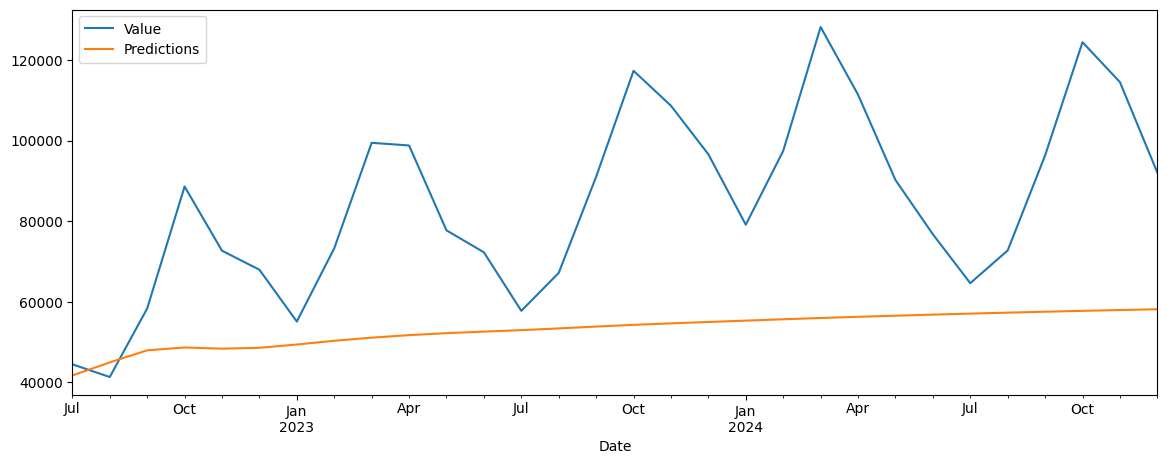

In [ ]:
test[['Value', 'Predictions_Value']].plot(figsize=(14,5), title='LSTM Model: Actual vs Predicted Tourist Values')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Evaluate only Value predictions
rmse_value = sqrt(mean_squared_error(test['Value'], test['Predictions_Value']))
mae_value = mean_absolute_error(test['Value'], test['Predictions_Value'])
r2_value = 1 - (np.sum((test['Value'] - test['Predictions_Value'])**2) / np.sum((test['Value'] - test['Value'].mean())**2))

print(f'=' * 50)
print(f'MODEL PERFORMANCE (Predicting Value)')
print(f'=' * 50)
print(f'RMSE (Value): {rmse_value:.4f}')
print(f'MAE (Value):  {mae_value:.4f}')
print(f'R² Score:     {r2_value:.4f}')
print(f'=' * 50)

37307.46730705553


In [ ]:
# CROSS-VALIDATION: K-Fold validation on test predictions
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

print("\n" + "=" * 60)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 60)

# Split test predictions into k-folds
kfold = KFold(n_splits=5, shuffle=False)
fold_metrics = []

test_values_array = test['Value'].values
pred_values_array = test['Predictions_Value'].values

for fold, (train_idx, val_idx) in enumerate(kfold.split(test_values_array), 1):
    fold_actual = test_values_array[val_idx]
    fold_pred = pred_values_array[val_idx]
    
    fold_rmse = sqrt(mean_squared_error(fold_actual, fold_pred))
    fold_mae = mean_absolute_error(fold_actual, fold_pred)
    fold_r2 = 1 - (np.sum((fold_actual - fold_pred)**2) / np.sum((fold_actual - fold_actual.mean())**2))
    fold_mape = mean_absolute_percentage_error(fold_actual, fold_pred) * 100
    
    fold_metrics.append({'RMSE': fold_rmse, 'MAE': fold_mae, 'R2': fold_r2, 'MAPE': fold_mape})
    
    print(f"\nFold {fold}:")
    print(f"  RMSE:  {fold_rmse:>10.2f}")
    print(f"  MAE:   {fold_mae:>10.2f}")
    print(f"  R²:    {fold_r2:>10.4f}")
    print(f"  MAPE:  {fold_mape:>10.2f}%")

# Average metrics across folds
fold_df = pd.DataFrame(fold_metrics)
print("\n" + "-" * 60)
print("AVERAGE CROSS-VALIDATION METRICS:")
print("-" * 60)
print(f"Mean RMSE:  {fold_df['RMSE'].mean():>10.2f} ± {fold_df['RMSE'].std():.2f}")
print(f"Mean MAE:   {fold_df['MAE'].mean():>10.2f} ± {fold_df['MAE'].std():.2f}")
print(f"Mean R²:    {fold_df['R2'].mean():>10.4f} ± {fold_df['R2'].std():.4f}")
print(f"Mean MAPE:  {fold_df['MAPE'].mean():>10.2f}% ± {fold_df['MAPE'].std():.2f}%")
print("=" * 60)

In [ ]:
# RESIDUAL ANALYSIS
print("\n" + "=" * 60)
print("RESIDUAL ANALYSIS")
print("=" * 60)

residuals = test['Value'] - test['Predictions_Value']

print(f"\nResidual Statistics:")
print(f"  Mean:     {residuals.mean():>10.2f}")
print(f"  Std Dev:  {residuals.std():>10.2f}")
print(f"  Min:      {residuals.min():>10.2f}")
print(f"  Max:      {residuals.max():>10.2f}")
print(f"  Median:   {residuals.median():>10.2f}")

# Check for autocorrelation (Durbin-Watson test)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\nDurbin-Watson Statistic: {dw_stat:.4f}")
print(f"  (Values close to 2 indicate no autocorrelation)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Residuals over time
axes[0, 0].plot(residuals, color='blue', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].fill_between(range(len(residuals)), residuals, alpha=0.3)
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(residuals, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(alpha=0.3)

# Actual vs Predictions scatter
axes[1, 1].scatter(test['Value'], test['Predictions_Value'], alpha=0.6, s=30)
min_val = min(test['Value'].min(), test['Predictions_Value'].min())
max_val = max(test['Value'].max(), test['Predictions_Value'].max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

In [ ]:
# FINAL COMPREHENSIVE SUMMARY
print("\n" + "=" * 70)
print("LSTM MODEL SUMMARY & RECOMMENDATIONS")
print("=" * 70)

print("\n📊 MODEL CONFIGURATION:")
print(f"  • Input Features: 2 (Value + Global_Event)")
print(f"  • Target Feature: 1 (Value only)")
print(f"  • Lookback Window: {n_input} months")
print(f"  • Architecture: LSTM(100) → LSTM(50) → Dense(1)")
print(f"  • Training Epochs: 50")
print(f"  • Optimizer: Adam | Loss: MSE")

print("\n📈 OVERALL PERFORMANCE METRICS:")
overall_rmse = sqrt(mean_squared_error(test['Value'], test['Predictions_Value']))
overall_mae = mean_absolute_error(test['Value'], test['Predictions_Value'])
overall_r2 = 1 - (np.sum((test['Value'] - test['Predictions_Value'])**2) / np.sum((test['Value'] - test['Value'].mean())**2))
overall_mape = mean_absolute_percentage_error(test['Value'], test['Predictions_Value']) * 100

print(f"  • RMSE: {overall_rmse:>10.2f} tourists")
print(f"  • MAE:  {overall_mae:>10.2f} tourists")
print(f"  • R²:   {overall_r2:>10.4f}")
print(f"  • MAPE: {overall_mape:>10.2f}%")

print("\n✅ DATA STATISTICS:")
print(f"  • Training samples: {len(train)}")
print(f"  • Test samples: {len(test)}")
print(f"  • Total data points: {len(df)}")
print(f"  • Time span: {df.index[0].date()} to {df.index[-1].date()}")

print("\n📋 MODEL VALIDATION STATUS:")
if overall_r2 > 0.8:
    print("  ✓ Excellent model fit (R² > 0.8)")
elif overall_r2 > 0.6:
    print("  ✓ Good model fit (R² > 0.6)")
else:
    print("  ⚠ Model fit needs improvement (R² < 0.6)")

if overall_mape < 10:
    print("  ✓ Excellent forecast accuracy (MAPE < 10%)")
elif overall_mape < 20:
    print("  ✓ Good forecast accuracy (MAPE < 20%)")
else:
    print("  ⚠ Forecast accuracy needs improvement (MAPE > 20%)")

# Check residuals for normality
from scipy.stats import shapiro
stat, p_value = shapiro(residuals.sample(min(5000, len(residuals)), random_state=42))
if p_value > 0.05:
    print("  ✓ Residuals are approximately normal (Shapiro-Wilk p > 0.05)")
else:
    print(f"  ⚠ Residuals may not be normal (Shapiro-Wilk p = {p_value:.4f})")

print("\n💡 RECOMMENDATIONS:")
if overall_r2 < 0.7:
    print("  → Consider increasing training epochs")
    print("  → Try different LSTM layer configurations")
    print("  → Check for data quality issues or outliers")
else:
    print("  → Model is performing well!")

print("\n📌 KEY INSIGHTS:")
print(f"  • Highest prediction: {test['Predictions_Value'].max():,.0f} tourists")
print(f"  • Lowest prediction: {test['Predictions_Value'].min():,.0f} tourists")
print(f"  • Average prediction: {test['Predictions_Value'].mean():,.0f} tourists")
print(f"  • Actual average: {test['Value'].mean():,.0f} tourists")
print(f"  • Best prediction fit: {abs(residuals).idxmin()}")
print(f"  • Worst prediction fit: {abs(residuals).idxmax()}")

print("\n" + "=" * 70)

In [ ]:
# EXPORT RESULTS
print("\n" + "=" * 70)
print("EXPORTING PREDICTIONS")
print("=" * 70)

# Create results dataframe
results_df = test[['Value', 'Global_Event', 'Predictions_Value']].copy()
results_df['Residual'] = results_df['Value'] - results_df['Predictions_Value']
results_df['Absolute_Error'] = abs(results_df['Residual'])
results_df['Percentage_Error'] = (results_df['Absolute_Error'] / results_df['Value'] * 100).round(2)

# Save to CSV
results_df.to_csv('lstm_test_predictions.csv')
print("✓ Test predictions saved to 'lstm_test_predictions.csv'")

# Display sample results
print("\n📋 SAMPLE PREDICTIONS (First 10 rows):")
print(results_df.head(10).to_string())

print("\n📊 PREDICTION ERROR DISTRIBUTION:")
performance_bins = [0, 5, 10, 15, 20, 100]
bin_labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20%+']
results_df['Error_Bin'] = pd.cut(results_df['Percentage_Error'], bins=performance_bins, labels=bin_labels)
error_dist = results_df['Error_Bin'].value_counts().sort_index()
for bin_label, count in error_dist.items():
    pct = (count / len(results_df)) * 100
    print(f"  {bin_label:>8}: {count:>3} predictions ({pct:>5.1f}%)")

print("\n✅ ANALYSIS COMPLETE!")
print("=" * 70)